In [3]:
import re
import numpy as np
import pandas as pd
import geopandas as gpd

Data

- Main cities: [site](https://hub.arcgis.com/maps/6837d1aa47b743ac9da875ca339714ab)

- Country and Territory: [site](https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/)

In [4]:
# country boundary
# country = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
# country = country[['NAME_LONG', 'geometry']]

path = 'data_raw/world-administrative-boundaries.geojson'
region = gpd.read_file(path)

region = region[['iso3', 'name', 'region', 'continent', 'geometry', 'color_code']] \
            .dropna(subset='iso3') \
            .sort_values(['continent', 'region', 'name'])
region['geometry'] = region['geometry'].buffer(0.)


# region_short_name = {
#     'Iran (Islamic Republic of)'                 : 'Iran',
#     'United States of America'                   : 'United States',
#     'U.K. of Great Britain and Northern Ireland' : 'United Kingdom'
# }

# region['short_name'] = region['name'].map(lambda x : region_short_name.get(x, x))

# region['x'] = region['geo_point_2d'].map(lambda x: dict(x)['lon'])
# region['y'] = region['geo_point_2d'].map(lambda x: dict(x)['lat'])
# ax = gpd.GeoSeries(gpd.points_from_xy(region['x'], region['y'])) \
#         .plot(color='red')


path = 'https://raw.githubusercontent.com/dieghernan/Country-Codes-and-International-Organizations/master/outputs/Countrycodes.csv'
code = pd.read_csv(path)
code = code[['ISO_3166_3', 'FIPS_GEC', 'NAME.EN', 'CAPITAL.EN']]

region = region.dropna(subset='iso3') \
            .merge(code, left_on='iso3', right_on='ISO_3166_3', how='left') \
            .drop('ISO_3166_3', axis=1) \
            # .dropna(subset='ISO_3166_3') \
region

,iso3,name,region,continent,geometry,color_code,FIPS_GEC,NAME.EN,CAPITAL.EN
0,IOT,British Indian Ocean Territory,Eastern Africa,Africa,"POLYGON ((72.48720 -7.38194, 72.43817 -7.43625...",IOT,IO,British Indian Ocean Territory,NaN
1,BDI,Burundi,Eastern Africa,Africa,"POLYGON ((30.57333 -2.39917, 30.52208 -2.46160...",BDI,BY,Burundi,Gitega
2,COM,Comoros,Eastern Africa,Africa,"MULTIPOLYGON (((44.48750 -12.09306, 44.51833 -...",COM,CN,Comoros,Moroni
3,DJI,Djibouti,Eastern Africa,Africa,"POLYGON ((43.24922 11.46953, 43.22500 11.43083...",DJI,DJ,Djibouti,Djibouti
4,ERI,Eritrea,Eastern Africa,Africa,"MULTIPOLYGON (((43.12138 12.70833, 42.92972 12...",ERI,ER,Eritrea,Asmara
...,...,...,...,...,...,...,...,...,...
233,PCN,Pitcairn Island,Polynesia,Oceania,"MULTIPOLYGON (((-128.29112 -24.41139, -128.301...",GBR,PC,Pitcairn Islands,Adamstown
234,WSM,Samoa,Polynesia,Oceania,"MULTIPOLYGON (((-171.42920 -14.01625, -171.441...",WSM,WS,Samoa,Apia
235,TKL,Tokelau,Polynesia,Oceania,"POLYGON ((-171.84376 -9.21083, -171.84806 -9.2...",TKL,TL,Tokelau,NaN
236,TON,Tonga,Polynesia,Oceania,"MULTIPOLYGON (((-173.90891 -18.63556, -173.986...",TON,TN,Tonga,Nuku'alofa


## Find Capital

In [5]:
# Main cities in the world
path = 'data_raw/world_cities.csv'
city = pd.read_csv(path)

city = gpd.GeoDataFrame(
    city[['CITY_NAME', 'FIPS_CNTRY', 'STATUS', 'X', 'Y']],
    geometry = gpd.points_from_xy(city['X'], city['Y']),
    crs = 'EPSG:4326')

# capital = city[city['STATUS'] == 'National and provincial capital']

region_city = region.sjoin(city, how='left') \
                .drop(['index_right'], axis=1) \
                .dropna() \

data_all = []

for ix, city_li in region_city.groupby('iso3'):

    city_li = city_li.squeeze()

    if isinstance(city_li, pd.Series):
        data_all.append(city_li)

    else:
        capital = city_li[city_li['STATUS'] == 'National and provincial capital']

        if capital.shape[0] == 1:
            capital = capital.squeeze()
            data_all.append(capital)

        elif capital.shape[0] == 0:
            pass

data_all = pd.DataFrame(data_all)
data_all = data_all[['iso3', 'CITY_NAME', 'X', 'Y']]
data_all

,iso3,CITY_NAME,X,Y
60,ABW,Oranjestad,-70.026003,12.525003
137,AFG,Kabul,69.136758,34.530912
20,AGO,Luanda,13.235004,-8.811999
58,AIA,The Valley,-63.066663,18.216666
188,ALB,Tirana,19.832004,41.331996
...,...,...,...,...
221,VUT,Port Vila,168.320997,-17.739999
234,WSM,Apia,-171.739494,-13.837023
164,YEM,Sanaa,44.209503,15.361443
18,ZMB,Lusaka,28.170000,-15.429996


In [6]:
region = region.merge(data_all, on='iso3', how='left') \
            .rename(columns = {'CAPITAL.EN' : 'capital' ,
                               'NAME.EN'    : 'short_name',
                               'FIPS_GEC'   : 'fips_gec',
                               'CITY_NAME'  : 'represent_city' })

for ix, row in region.copy().iterrows():
    if pd.isna(row['represent_city']):
        point = row['geometry'].representative_point().coords[0]
        region.loc[ix, 'X'] = point[0]
        region.loc[ix, 'Y'] = point[1]

In [7]:
region.to_file('data_result/region_with_city.geojson')
# region = gpd.read_file('data_result/region_with_city.geojson')

<AxesSubplot: >

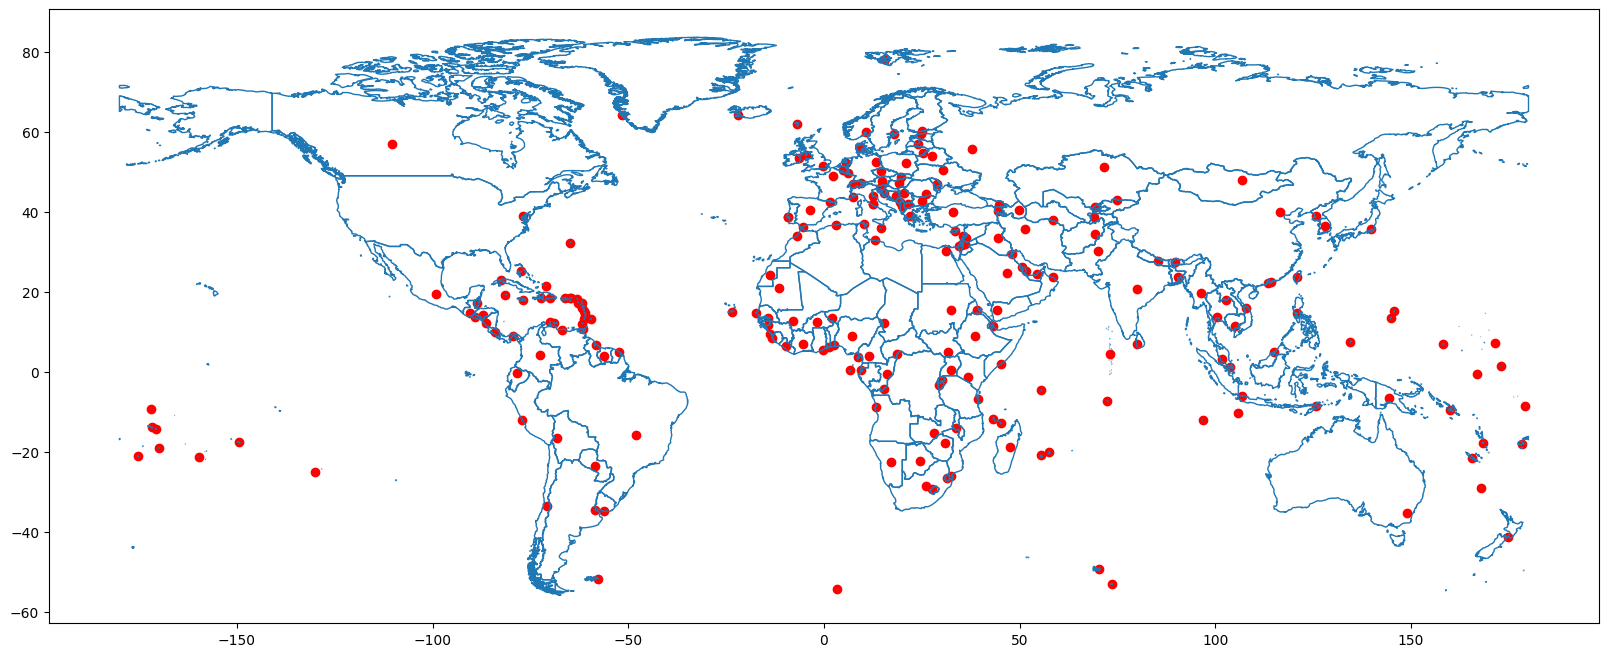

In [8]:
ax = region.boundary.plot(lw=1, figsize=(20, 10))
gpd.GeoSeries(gpd.points_from_xy(region['X'], region['Y']), crs=region.crs) \
        .plot(ax=ax, color='red')